# CAFA-6 Protein Function Prediction

## 01: Data Exploration and Preprocessing 

## Mục tiêu
- Cho góc nhìn toàn cảnh Data trong dự án 
- EDA của Dataset
- Load và parse GO ontology
- Load và phân tích các chuỗi protein
- Load training labels và taxonomy
- Xây dựng GO hierachy --> 
- Mô hình hoá những thông tin quan trọng 



## GO (gene ontology):
- GO dùng để phân tích chức năng protein 
- So sánh sinh vật :V --> Giải thích kết quả thí nghiệm 
## 3 miền
1. Biological Process (BP):
    - Mô tả quá trình sinh học protein tham gia 
2. Molecular Function (MF):
    - Mô tả chức năng phân tử cơ bản của protein
3. Cellular Component (CC):
    - Mô tả vị trí trong tế bào nơi protein hoạt động.



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import obonet
import networkx as nx
from Bio import SeqIO
import os
import warnings
# Bỏ qua vài thông báo, có thể không quan trọng 
warnings.filterwarnings('ignore')

# Chọn style biểu đồ đẹp hơn --> Chọn kiểu cho matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
# Đổi bảng màu tươi cho sns
sns.set_palette("husl")

# config link data
BASE_DIR = "/Users/user/ML/CreatineML"
TRAIN_DIR = os.path.join(BASE_DIR, 'Train')
TEST_DIR = os.path.join(BASE_DIR, 'Test')

#check
print("Done")


Done


## 2. Load GO Ontology

In [4]:
# load GO từ file OBO
obo_file = os.path.join(TRAIN_DIR, "go-basic.obo")
# Chuyển Go thành dạng Graph
graph = obonet.read_obo(obo_file)
go_graph = graph
ROOT_TERMS = {
    'BPO': 'GO:0008150',  # Biological Process
    'CCO': 'GO:0005575',  # Cellular Component
    'MFO': 'GO:0003674'   # Molecular Function
}

# Tạo mapping từ GO ID đến namépace
go_id_to_namespace = {}
go_id_to_name = {}
go_id_to_defination = {}

for node_id, data in go_graph.nodes(data=True):
    go_id_to_namespace[node_id] = data.get('namespace', 'unknown')
    go_id_to_name[node_id] = data.get('name', '')
    go_id_to_defination[node_id] = data.get('def', '')

print(f"Tổng số GO terms: {len(go_id_to_namespace)}")
print(f"\nRoot terms:")
for ont, root_id in ROOT_TERMS.items():
    print(f"{ont}: {root_id} - {go_id_to_name.get(root_id, "N/A")}")

# Đếm số terms theo namespace
namespace_counts = Counter(go_id_to_namespace.values())
print(f"\nSố lượng terms theo namespace:")
for ns, count in namespace_counts.items():
    print(f"  {ns}: {count}")

Tổng số GO terms: 40122

Root terms:
BPO: GO:0008150 - biological_process
CCO: GO:0005575 - cellular_component
MFO: GO:0003674 - molecular_function

Số lượng terms theo namespace:
  biological_process: 25950
  molecular_function: 10131
  cellular_component: 4041



- Trích xuất thông tin cơ bản cho mỗi GO term
- Ta có thông tin về tổng số term, số term của từng loại và tên đi kèm 

### Chú thích:
GO là đồ thị có hướng không chu trình (DAG) - do vậy ta có thể coi term là 1 node nào đó bên trong cái cây to đó 
- Ancestors là các node cha (node trên) --> Cho phép bến node hiện tại xét thuộc nhóm nào 
- Descendants là các node con (node dưới - hậu duệ) --> Có thể hiểu nó giúp phân giã hành vi của node con hiện tại 1 cách cụ thể hơn 

In [7]:
# Ancestors/ Descendants --> Ta sẽ lấy 2 tập này bằng BFS
def get_ancestors(go_id, graph):
    # Ta sẽ lấy full các ancestors của 1 GO term
    ancestors = set()
    queue = [go_id]
    while queue:
        current = queue.pop(0)
        if(current in ancestors):
            continue
        ancestors.add(current)
        for parent in graph.predecessors(current):
            if(parent not in ancestors):
                queue.append(parent)
    return ancestors

def get_descendants(go_id, graph):
    descendants = set()
    queue = [go_id]
    while queue:
        current = queue.pop(0)
        if current in descendants:
            continue
        descendants.add(current)
        # Lấy children
        for child in graph.successors(current):
            if child not in descendants:
                queue.append(child)
    return descendants

# Test với một GO term
test_term = 'GO:0005515'  # protein binding
ancestors = get_ancestors(test_term, go_graph)
descendants = get_descendants(test_term, go_graph)

print(f"Test term: {test_term} - {go_id_to_name.get(test_term, 'N/A')}")
print(f"Số ancestors: {len(ancestors)}")
print(f"Số descendants: {len(descendants)}")
print(f"\nMột số ancestors:")
for i, anc in enumerate(list(ancestors)[:5]):
    print(f"  {anc}: {go_id_to_name.get(anc, 'N/A')}")

print(f"\nMột số descendants:")
for i, anc in enumerate(list(descendants)[:3]):
    print(f"  {anc}: {go_id_to_name.get(anc, 'N/A')}")

Test term: GO:0005515 - protein binding
Số ancestors: 909
Số descendants: 3

Một số ancestors:
  GO:0031624: ubiquitin conjugating enzyme binding
  GO:0070016: armadillo repeat domain binding
  GO:0031717: cannabinoid receptor binding
  GO:0030156: benzodiazepine receptor binding
  GO:0046659: digestive hormone activity

Một số descendants:
  GO:0005515: protein binding
  GO:0003674: molecular_function
  GO:0005488: binding


## 3. Load Training Labels

Oke thì ta sẽ phải hiểu Training Labels là gì --> training labels trong bài toán này là danh sách các GO terms thật mà 1 protein đã được gán trong thực tế (nó là 1 cụm các term của 1 protein trong thực tế - sai thì ae sửa hộ nhé)

### MỤC ĐÍCH:
1. Huấn luyện mô hình --> Dùng để dạy mô hình biết protein thuộc GO nào ?
2. Propagate labels theo DAG --> Đảm bảo dữ liệu hợp lệ với hệ thống phân tầng của GO
3. Đánh giá, thống kê, chuẩn hoá dữ liệu --> Check, fill, fix labels



In [10]:
# Load
# train_terms.tsv là nơi chưa nhãn GO thật thật cho các protein dùng để training
train_terms_file = os.path.join(TRAIN_DIR, "train_terms.tsv")
train_terms = pd.read_csv(train_terms_file, sep="\t")
print(f"shape: {train_terms.shape}")
print(f"\nVài hàng đầu: ")
print(train_terms.head(10))

print(f"\nTên cột: {train_terms.columns.tolist()}")
print(f"\nASpect distribution:{train_terms['aspect'].value_counts()}")

# Mapping aspect --> Chuyển kí tự sang fullname aspect 
## BP --> Protein tham gia quá trình sinh học nào ?
## MF --> Tác dụng trực tiếp ở mức phân tử
## CC --> Vị trí protein trong tế bào
aspect_map = {'P': 'Biological Process', 'F': 'Molecular Function', 'C':'Cellular Component'}
train_terms['aspect_name'] = train_terms['aspect'].map(aspect_map)
print(f"\nAspect distribution (names):")
print(train_terms['aspect_name'].value_counts())


shape: (537027, 3)

Vài hàng đầu: 
  EntryID        term aspect
0  Q5W0B1  GO:0000785      C
1  Q5W0B1  GO:0004842      F
2  Q5W0B1  GO:0051865      P
3  Q5W0B1  GO:0006275      P
4  Q5W0B1  GO:0006513      P
5  Q5W0B1  GO:0003682      F
6  Q5W0B1  GO:0005515      F
7  Q3EC77  GO:0000138      C
8  Q3EC77  GO:0005794      C
9  Q8IZR5  GO:0005515      F

Tên cột: ['EntryID', 'term', 'aspect']

ASpect distribution:aspect
P    250805
C    157770
F    128452
Name: count, dtype: int64

Aspect distribution (names):
aspect_name
Biological Process    250805
Cellular Component    157770
Molecular Function    128452
Name: count, dtype: int64


In [15]:
# Thống kê labels
unique_proteins = train_terms['EntryID'].nunique()
unique_terms = train_terms['term'].nunique()
avg_terms_per_protein = train_terms.groupby('EntryID')['term'].count().mean()

print(f"Số lượng protein duy nhất: {unique_proteins:,}")
print(f"Số lượng GO terms duy nhất: {unique_terms:,}")
print(f"Trung bình số terms mỗi protein: {avg_terms_per_protein:.2f}")

# Phân phối của số terms trong mỗi 1 protein 
terms_per_protein = train_terms.groupby('EntryID')['term'].count()
print(f"\nThống kê -> terms_per_protein:\n{terms_per_protein.describe()}")

# BXH GO terms popular
top_terms = train_terms['term'].value_counts().head(20) #20 cháu đi
print(f"\nTop 20 phổ biến:")
for term, count in top_terms.items():
    term_name = go_id_to_name.get(term, 'N/A')
    print(f"  {term} ({term_name[:50]}): {count:,}")


Số lượng protein duy nhất: 82,404
Số lượng GO terms duy nhất: 26,125
Trung bình số terms mỗi protein: 6.52

Thống kê -> terms_per_protein:
count    82404.000000
mean         6.517002
std          7.965655
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max        233.000000
Name: term, dtype: float64

Top 20 phổ biến:
  GO:0005515 (protein binding): 33,713
  GO:0005634 (nucleus): 13,283
  GO:0005829 (cytosol): 13,040
  GO:0005886 (plasma membrane): 10,150
  GO:0005737 (cytoplasm): 9,442
  GO:0005739 (mitochondrion): 5,807
  GO:0005654 (nucleoplasm): 5,065
  GO:0016020 (membrane): 3,563
  GO:0042802 (identical protein binding): 3,547
  GO:0005576 (extracellular region): 3,241
  GO:0005783 (endoplasmic reticulum): 2,837
  GO:0005615 (extracellular space): 2,391
  GO:0045944 (positive regulation of transcription by RNA polyme): 2,319
  GO:0070062 (extracellular exosome): 2,130
  GO:0005794 (Golgi apparatus): 2,045
  GO:0005730 (nucleolus): 1,789
  G

## 4. Load Protein Sequences

In [30]:
# Load file chứa chuỗi Amino acid của các protein train
train_fasta_file = os.path.join(TRAIN_DIR, 'train_sequences.fasta')
sequences = {}
sequence_lengths = []
sample_size = 10000 #Đọc 10k sequences đầu
count = 0

for record in SeqIO.parse(train_fasta_file, "fasta"):
    if count >= sample_size:
        break
    seq_id = record.id.split("|")[1] if '|' in record.id else record.id.split()[0]
    seq = str(record.seq)
    sequences[seq_id] = seq
    sequence_lengths.append(len(seq))
    count+=1

print(f"Đã load {len(sequences):,} sequences (sample)")
print(f"Độ dài trung bình: {np.mean(sequence_lengths):.2f} amino acids")
print(f"Độ dài min: {min(sequence_lengths)}")
print(f"Độ dài max: {max(sequence_lengths)}")
print(f"Độ dài median: {np.median(sequence_lengths):.2f}")

#sample sequences
print(f"\nMột vài sequences mẫu:")
for i, (seq_id, seq) in enumerate(list(sequences.items())[:3]):
    print(f"\n{seq_id}: {seq[:100]}... (length: {len(seq)})")

print("\n")

# Đọc toàn bộ file để lấy thống kê chính xác về độ dài
all_lengths = []
total_seqs = 0

for record in SeqIO.parse(train_fasta_file, "fasta"):
    all_lengths.append(len(record.seq))
    total_seqs += 1

print(f"\nTổng số sequences: {total_seqs:,}")
print(f"Thống kê độ dài sequences:")
length_stats = pd.Series(all_lengths).describe()
print(length_stats)

Đã load 10,000 sequences (sample)
Độ dài trung bình: 611.94 amino acids
Độ dài min: 16
Độ dài max: 34350
Độ dài median: 458.00

Một vài sequences mẫu:

A0A0C5B5G6: MRWQEMGYIFYPRKLR... (length: 16)

A0JNW5: MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVLQNMLDLPTWLAINKVFCNKASIRIPWTKLKTHPICLSLDKVIMEMSTCEEPRSP... (length: 1464)

A0JP26: MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTSGDHDDSFMKTLRSKMGKCCHHCFPCCRGSGTSNVGTSGDHDNSFMKTLRSKMGK... (length: 581)



Tổng số sequences: 82,404
Thống kê độ dài sequences:
count    82404.000000
mean       525.788287
std        521.574869
min          3.000000
25%        250.000000
50%        409.000000
75%        630.000000
max      35213.000000
dtype: float64


## 5. Load Taxonomy và IA Weights

### Taxonomy - hệ phân loại sinh học của loài
- Mỗi protein trong dataset sẽ thuộc về 1 organism (org --> species --> taxon_id).
- Trong dự đoán chức năng protein --> Taxonomy quan trọng vì:
    + Proteins từ loài khác nhau (người vs chuột) có chức năng khác nhau
    + Dữ liệu GO annotation giữa các loài k cân bằng --> Cần biết thuộc loài nào để điều chỉnh loss/ độ tin cậy prediction

### IA Weight - thước đo mức độ thông tin của 1 GO term
- IA(term)=−log2​(probability of term in dataset)
    + GO term càng hiếm --> IA càng lớn
    + GO term phổ biến --> IA càng nhỏ
- Dùng để đánh giá mô hình 
    + thưởng/ phạt các kiểu 
    + Dùng để phân biệt rare/common GO term

In [32]:
# Load taxonomy
taxonomy_file = os.path.join(TRAIN_DIR, 'train_taxonomy.tsv')

taxonomy = pd.read_csv(taxonomy_file, sep='\t', header=None, names=['EntryID', 'taxon_id'])
print(f"Shape: {taxonomy.shape}")
print(f"\nVài hàng đầu:")
print(taxonomy.head(10))

print(f"\nSố lượng species duy nhất: {taxonomy['taxon_id'].nunique()}")
print(f"\nTop 10 species:")
print(taxonomy['taxon_id'].value_counts().head(10))

Shape: (82404, 2)

Vài hàng đầu:
      EntryID  taxon_id
0  A0A0C5B5G6      9606
1      A0JNW5      9606
2      A0JP26      9606
3      A0PK11      9606
4      A1A4S6      9606
5      A1A519      9606
6      A1L190      9606
7      A1L3X0      9606
8      A1X283      9606
9      A2A2Y4      9606

Số lượng species duy nhất: 1381

Top 10 species:
taxon_id
9606      17162
10090     12508
3702      11863
559292     5520
10116      4909
284812     4636
83333      3466
7227       3201
6239       2540
83332      1530
Name: count, dtype: int64


In [34]:
# Load IA 
ia_file = os.path.join(BASE_DIR, 'IA.tsv')

ia_weights = pd.read_csv(ia_file, sep='\t', header=None, names=['term', 'ia_weight'])
print(f"Shape: {ia_weights.shape}")
print(f"\nVài hàng đầu:")
print(ia_weights.head(10))

print(f"\nThống kê IA weights:")
print(ia_weights['ia_weight'].describe())

# Merge với GO terms trong training set
train_terms_with_ia = train_terms.merge(ia_weights, left_on='term', right_on='term', how='left')
print(f"\nSố GO terms có IA weight: {train_terms_with_ia['ia_weight'].notna().sum():,}")
print(f"Số GO terms không có IA weight: {train_terms_with_ia['ia_weight'].isna().sum():,}")


Shape: (40122, 2)

Vài hàng đầu:
         term  ia_weight
0  GO:0000001   0.000000
1  GO:0000002   2.849666
2  GO:0000011   0.137504
3  GO:0000012   6.038630
4  GO:0000017   0.514573
5  GO:0000018   1.879637
6  GO:0000019   3.584963
7  GO:0000022   0.000000
8  GO:0000023   3.311586
9  GO:0000024   0.000000

Thống kê IA weights:
count    40122.000000
mean         1.716517
std          2.637009
min          0.000000
25%          0.000000
50%          0.150287
75%          2.705504
max         14.861014
Name: ia_weight, dtype: float64

Số GO terms có IA weight: 537,027
Số GO terms không có IA weight: 0


## 6. Mô hình hoá

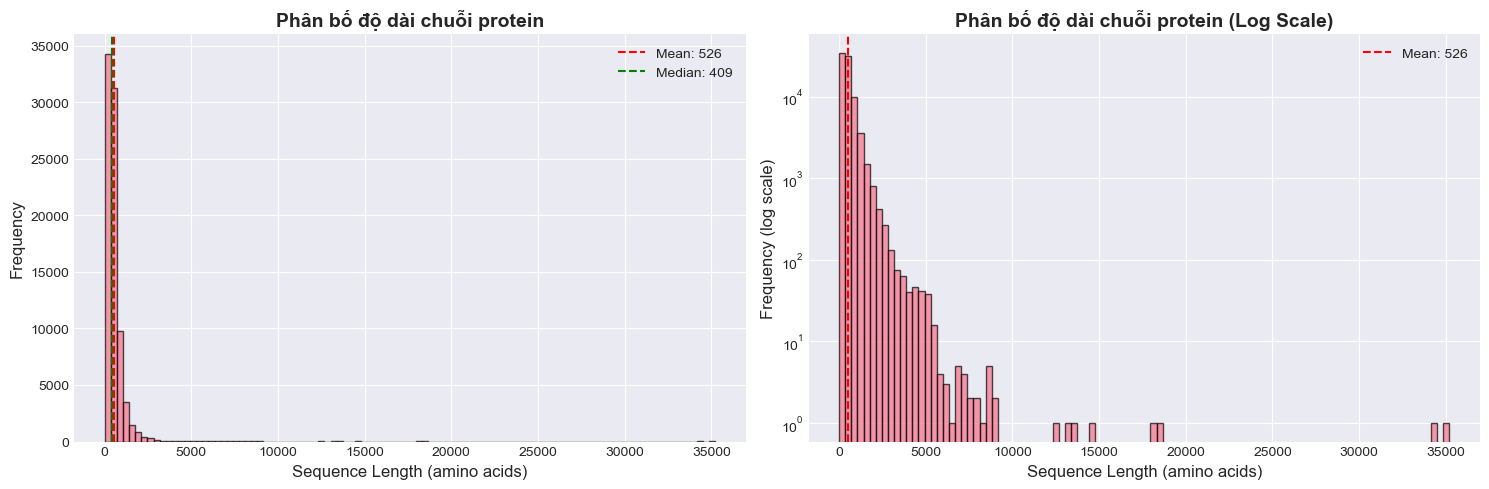

In [37]:
# Visualization 1: Phân phối độ dài Protein
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(all_lengths, bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Sequence Length (amino acids)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Phân bố độ dài chuỗi protein', fontsize=14, fontweight='bold')
axes[0].axvline(np.mean(all_lengths), color='r', linestyle='--', label=f'Mean: {np.mean(all_lengths):.0f}')
axes[0].axvline(np.median(all_lengths), color='g', linestyle='--', label=f'Median: {np.median(all_lengths):.0f}')
axes[0].legend()

# Log scale
axes[1].hist(all_lengths, bins=100, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Sequence Length (amino acids)', fontsize=12)
axes[1].set_ylabel('Frequency (log scale)', fontsize=12)
axes[1].set_title('Phân bố độ dài chuỗi protein (Log Scale)', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')
axes[1].axvline(np.mean(all_lengths), color='r', linestyle='--', label=f'Mean: {np.mean(all_lengths):.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()


### Đánh giá Visualization 1:
1. Biểu đồ 1: Histogram thường --> Quan sát tổng quát
2. Biểu đồ 2: Đánh giá đuôi (phải)
    - Phân bố lệch phải mạnh (đuôi kéo dài tới > 35k aa, nhưng tần suất thấp)
    - Median < Mean --> Phân bố bị kéo lệch vì Outliers (Median ~ 409aa/ Mean ~ 526aa) --> Do đó avg bị tăng lên bởi 1 số đoạn protein rất dài
    - Nhóm chính trong khoảng 100 -> 600 aa
3. Ý nghĩa sinh học (bonus):
    - Nhóm <100 aa: peptides, hormone, tín hiệu ngắn
    - Nhóm 100–1000 aa: enzyme, receptor, functional proteins
    - Nhóm >5000 aa: structural proteins, titin-like
    - Nhóm >10,000 aa: rất hiếm, có thể chứa nhiều repeat hoặc lỗi chú thích



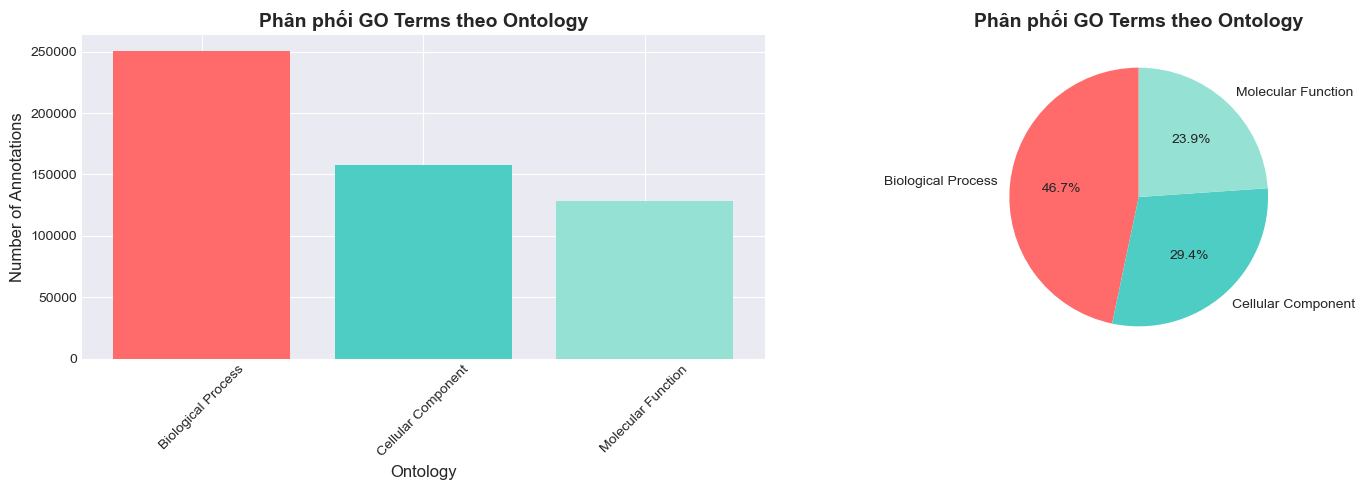

In [39]:
# Visualization 2: Phân phối Aspect
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
aspect_counts = train_terms['aspect_name'].value_counts()
axes[0].bar(aspect_counts.index, aspect_counts.values, color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
axes[0].set_xlabel('Ontology', fontsize=12)
axes[0].set_ylabel('Number of Annotations', fontsize=12)
axes[0].set_title('Phân phối GO Terms theo Ontology', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
axes[1].pie(aspect_counts.values, labels=aspect_counts.index, autopct='%1.1f%%', 
            colors=['#FF6B6B', '#4ECDC4', '#95E1D3'], startangle=90)
axes[1].set_title('Phân phối GO Terms theo Ontology', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Đánh giá Visualization 2:
- Trên đây đã cho ta cái nhìn tổng quan về phân phối số lượng theo Ontology 
- Data không cân bằng giữa các Ontology --> Nếu dùng dữ liệu này để huấn luyện mô hình dự đoán GO terms, cần cân nhắc về vấn đề imbalance (mô hình sẽ bị thiên vị cho BP) - ý kiến cá nhân
- Có thể áp dụng weighted loss để cân bằng data khi huấn luyện mô hình 

In [ ]:
# Visualization 3: Phân phối Terms của mỗi Proterin
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(terms_per_protein.values, bins=50, edgecolor='black', alpha=0.7, color='#A8E6CF')
axes[0].set_xlabel('Số lượng Term/Protein', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Phân phối Term trong mỗi Protein', fontsize=14, fontweight='bold')
axes[0].axvline(terms_per_protein.mean(), color='r', linestyle='--', 
                label=f'Mean: {terms_per_protein.mean():.2f}')
axes[0].legend()

# Box plot
axes[1].boxplot(terms_per_protein.values, vert=True)
axes[1].set_ylabel('Số lượng Term/Protein', fontsize=12)
axes[1].set_title('Phân phối Term trong mỗi Protein', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()